## Grouped stations models

In [30]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

In [31]:
### division by river valley
files_ids ={'pastaza':{'banos':'banos_validation.csv'},
'cutuchi':{'aeropuerto': 'aeropuerto_validation.csv',
           'pisayambo':'pisayambo_validation.csv',
           'JAlvarez':'JAlvarez_validation.csv',
           'tasinteo':'tasinteo_validation.csv'},
'patate':{'guadalupe':'guadalupe_validation.csv',
          'AJSucre':'AJSucre_validation.csv'},
'ambato':{'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',     
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv'}}

In [32]:
### division by temperature
# files_ids ={'high':{'banos':'banos_validation.csv',
#                     'guadalupe':'guadalupe_validation.csv'},
#             'medium':{'aeropuerto': 'aeropuerto_validation.csv',
#                       'JAlvarez':'JAlvarez_validation.csv',
#                       'AJSucre':'AJSucre_validation.csv',
#                       'pfc-hgpt':'pfc-hgpt_validation.csv'},
#             'low':{'pisayambo':'pisayambo_validation.csv',
#                    'tasinteo':'tasinteo_validation.csv',
#                    'quisapincha':'quisapincha_validation.csv',
#                    'chiquiurco':'chiquiurco_validation.csv',     
#                    'calamaca':'calamaca_validation.csv',
#                    'mulaCorral':'mulaCorral_validation.csv',
#                    'pampasSalasaca':'pampasSalasaca_validation.csv'}}

In [33]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

cuencas = ['pastaza','cutuchi','patate','ambato']
#cuencas = ['high','medium','low']
cuenca = cuencas[1]

In [34]:
files_ids[cuenca].keys()

dict_keys(['aeropuerto', 'pisayambo', 'JAlvarez', 'tasinteo'])

In [35]:
def selectCols(df):
  d = dict(zip(df.columns[1:20],df.columns[1:20]+f'_{station[0:3]}'))
  df = df[['Date_Time', 'ATAvg', 'RHAvg','WDAvg','WSAvg','WAvgx', 'WAvgy','Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]
  df.rename(columns=d, inplace= True)
  df.set_index('Date_Time', inplace =True)
  df.index = pd.to_datetime(df.index)
  return df

In [36]:
### combine all stations in one df
for idx, station in enumerate(files_ids[cuenca].keys()):
    if idx == 0:
        df = pd.read_csv(f'{input_path}/{station}_validation.csv')
        merged = selectCols(df)
    else:
        df1 = pd.read_csv(f'{input_path}/{station}_validation.csv')
        df1 = selectCols(df1)
        merged=pd.merge(merged,df1, how='inner', left_index=True, right_index=True)
    

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
merged.columns

Index(['ATAvg_aer', 'RHAvg_aer', 'WDAvg_aer', 'WSAvg_aer', 'WAvgx_aer',
       'WAvgy_aer', 'Day_sin_aer', 'Day_cos_aer', 'Year_sin_aer',
       'Year_cos_aer', 'ATAvg_pis', 'RHAvg_pis', 'WDAvg_pis', 'WSAvg_pis',
       'WAvgx_pis', 'WAvgy_pis', 'Day_sin_pis', 'Day_cos_pis', 'Year_sin_pis',
       'Year_cos_pis', 'ATAvg_JAl', 'RHAvg_JAl', 'WDAvg_JAl', 'WSAvg_JAl',
       'WAvgx_JAl', 'WAvgy_JAl', 'Day_sin_JAl', 'Day_cos_JAl', 'Year_sin_JAl',
       'Year_cos_JAl', 'ATAvg_tas', 'RHAvg_tas', 'WDAvg_tas', 'WSAvg_tas',
       'WAvgx_tas', 'WAvgy_tas', 'Day_sin_tas', 'Day_cos_tas', 'Year_sin_tas',
       'Year_cos_tas'],
      dtype='object')

In [38]:
merged.head()

,ATAvg_aer,RHAvg_aer,WDAvg_aer,WSAvg_aer,WAvgx_aer,WAvgy_aer,Day_sin_aer,Day_cos_aer,Year_sin_aer,Year_cos_aer,...,ATAvg_tas,RHAvg_tas,WDAvg_tas,WSAvg_tas,WAvgx_tas,WAvgy_tas,Day_sin_tas,Day_cos_tas,Year_sin_tas,Year_cos_tas
Date_Time,,,,,,,,,,,,,,,,,,,,,
2013-05-08 14:20:00,21.08,50.96,158.27,4.89,-4.542511,1.810440,-0.573576,-0.819152,0.805618,-0.592436,...,12.078,91.97,207.79,2.92,-2.583214,-1.361398,-0.573576,-0.819152,0.805618,-0.592436
2013-05-08 14:25:00,21.37,50.40,158.27,4.50,-4.180225,1.666049,-0.591310,-0.806445,0.805582,-0.592484,...,11.840,91.97,207.79,2.92,-2.583214,-1.361398,-0.591310,-0.806445,0.805582,-0.592484
2013-05-08 14:30:00,21.04,50.45,158.27,4.07,-3.780781,1.506849,-0.608761,-0.793353,0.805547,-0.592532,...,11.850,91.97,207.79,2.92,-2.583214,-1.361398,-0.608761,-0.793353,0.805547,-0.592532
2013-05-08 14:35:00,21.58,48.53,158.27,4.03,-3.743624,1.492040,-0.625923,-0.779884,0.805512,-0.592580,...,11.792,91.97,207.79,2.92,-2.583214,-1.361398,-0.625923,-0.779884,0.805512,-0.592580
2013-05-08 14:40:00,20.64,49.21,158.27,3.71,-3.446363,1.373565,-0.642788,-0.766044,0.805476,-0.592628,...,11.914,91.97,207.79,2.92,-2.583214,-1.361398,-0.642788,-0.766044,0.805476,-0.592628


In [39]:
print(f'len = {len(merged)}')
merged.drop_duplicates(keep = 'first',inplace=True)
print(f'len (after duplicate drop) = {len(merged)}')

len = 701535
len (after duplicate drop) = 701535


In [40]:
merged.isnull().values.any()

False

In [41]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = merged[0::steps]

In [42]:
print(f'starts at = {df.index.min().date()}')
print(f'ends at = {df.index.max().date()}')

starts at = 2013-05-08
ends at = 2020-01-08


In [43]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(df.columns))) 

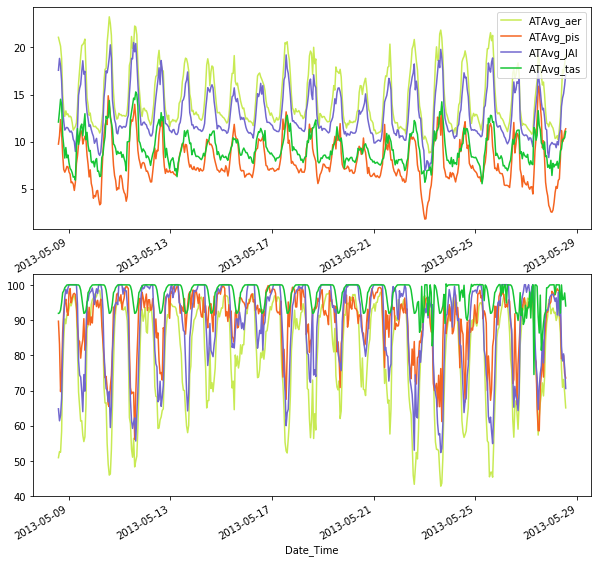

In [44]:
### Plot temperature
 # View corrected values
colors = ['#c8ea53','#f56420','#7167ce','#15c534','#e9dc09','#38a9f0','#702dae']
model_color = dict(zip(temp,colors))

fig, axes = plt.subplots(2,1,figsize= (10,10))
for a in range(0,len(temp)):
    df[temp[a]][:480].plot(ax = axes[0],color = model_color[temp[a]])
    df[rh[a]][:480].plot(ax = axes[1],color = model_color[temp[a]])
    axes[0].legend()
plt.savefig(f'{path}/{cuenca}_temp_rh.png', dpi = 100,bbox_inches='tight')

In [45]:
# ### Plot temperature
# plot_cols = temp
# plot_features = df[plot_cols]
# #plot_features.index = date_time
# _ = plot_features.plot(subplots=True, figsize = (10,15))

# plot_features = df[plot_cols][:480]
# #plot_features.index = date_time[:480]
# _ = plot_features.plot(subplots=True,figsize = (10,15))

In [46]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [47]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

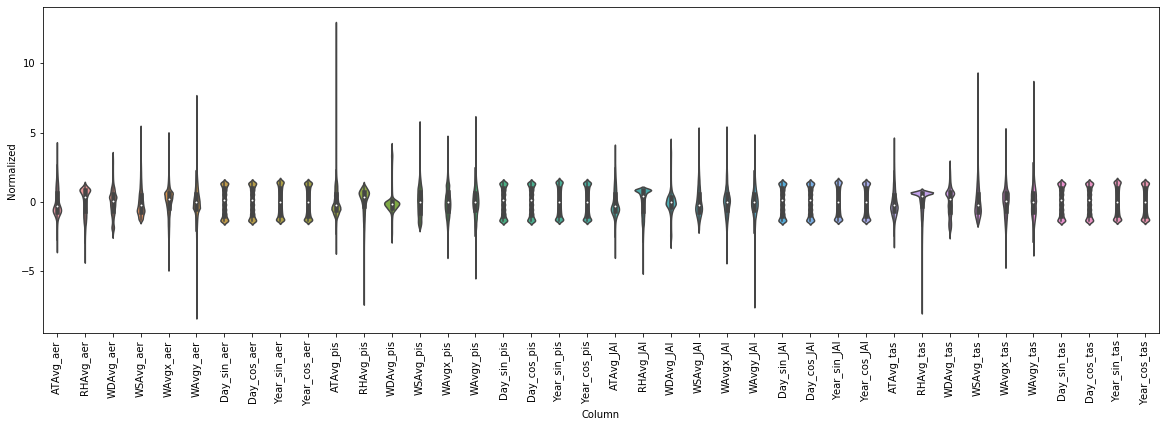

In [48]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(20, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

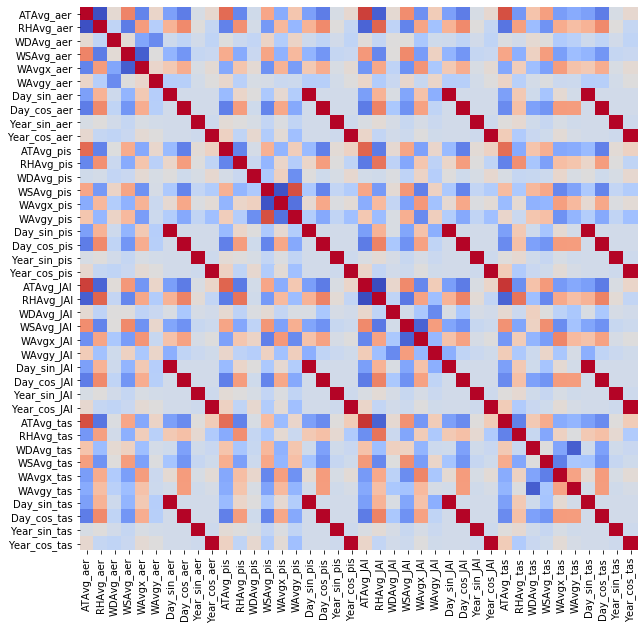

In [49]:
## correlations matrix of variables
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(), annot=False, fmt='.2f', 
            cmap='coolwarm', cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig.savefig(f'{path}/{cuenca}_stations_corrmatrix.png',dpi = 75)

## Run models

In [50]:
## read functions
%run model_utils.ipynb

In [51]:
station = cuenca
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables

### 24 h + 12h

365/365 [==============================] - 2s 5ms/step - loss: 0.3042 - mean_absolute_error: 0.3160


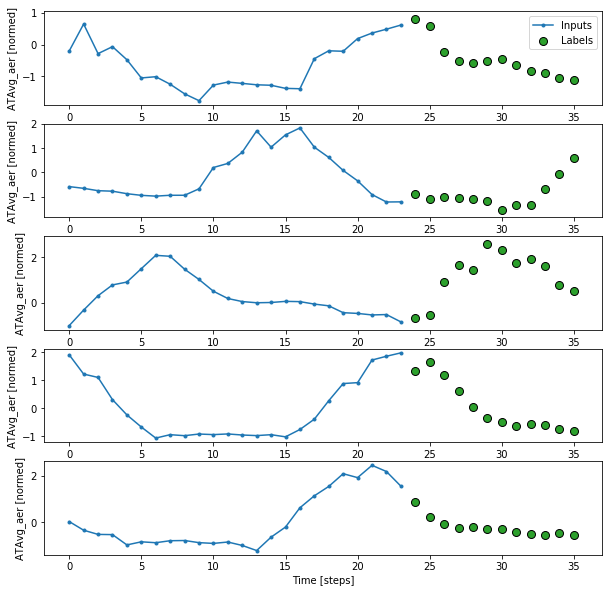

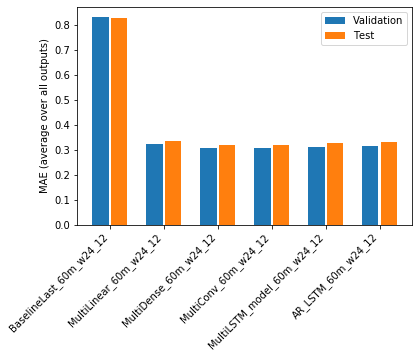

In [52]:
input_width = 24*time_steps
OUT_STEPS =12*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots =10, nrows=3, ncols = 3)

### 24 h + 24h

364/364 [==============================] - 3s 8ms/step - loss: 0.3156 - mean_absolute_error: 0.3204


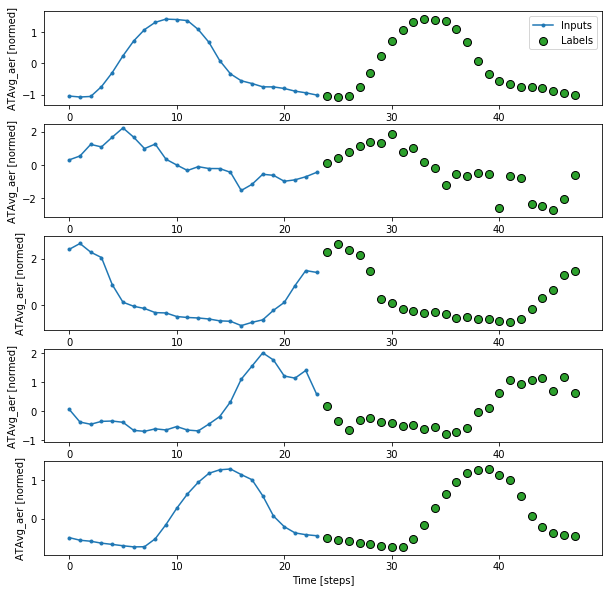

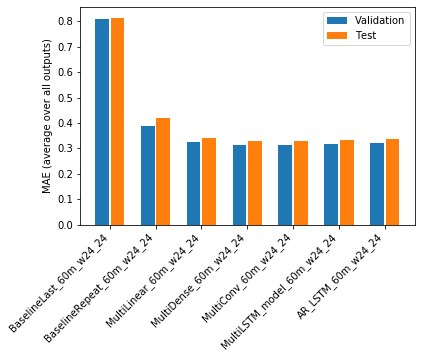

In [53]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)

### 48 h + 24h

364/364 [==============================] - 4s 9ms/step - loss: 0.3162 - mean_absolute_error: 0.3243


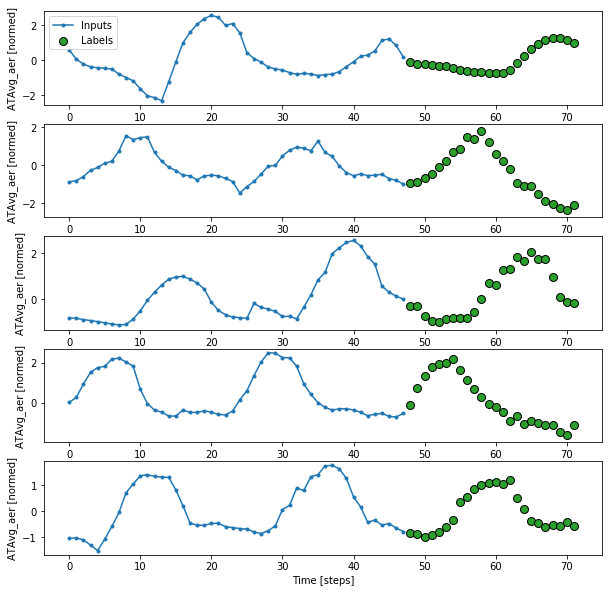

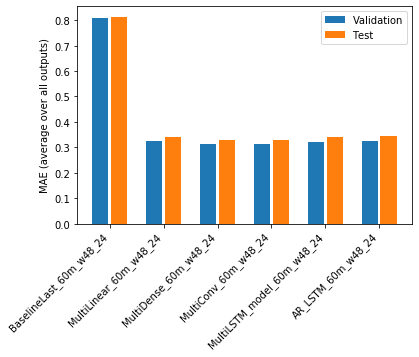

In [54]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)

### 48 h + 48h

363/363 [==============================] - 3s 9ms/step - loss: 0.3276 - mean_absolute_error: 0.3302


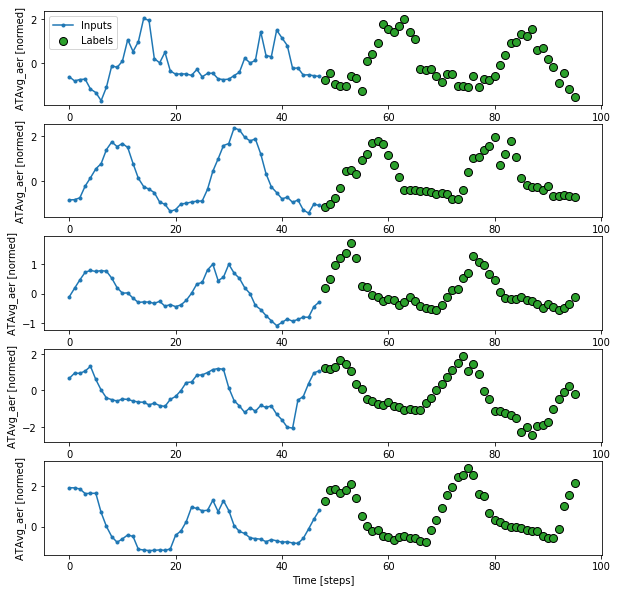

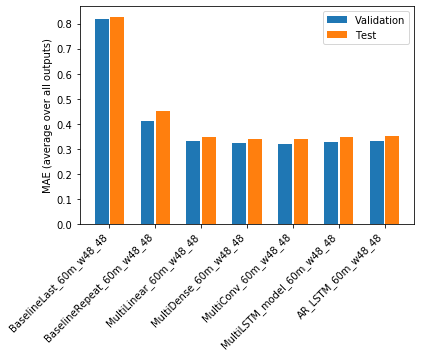

In [55]:
input_width = 48*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)

### 72 h + 12h

363/363 [==============================] - 3s 8ms/step - loss: 0.3041 - mean_absolute_error: 0.3160


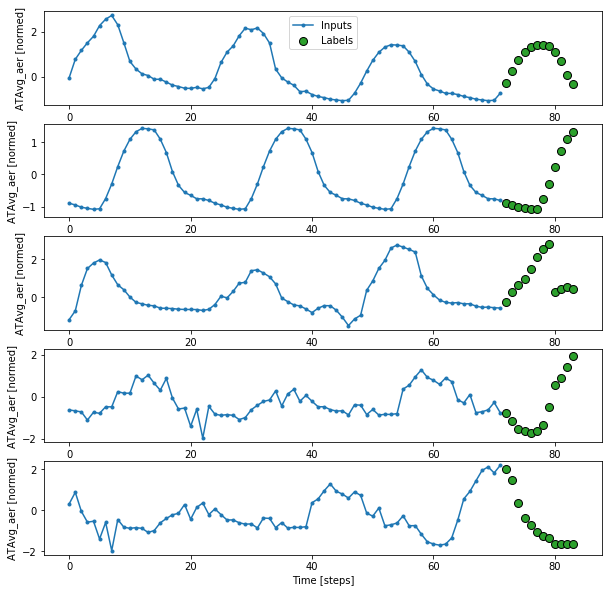

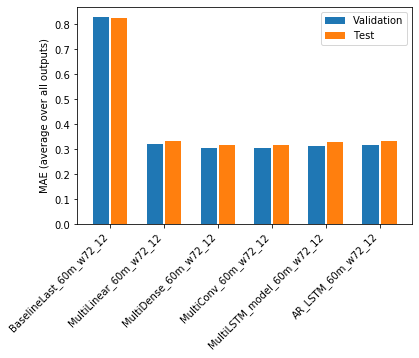

In [56]:
input_width = 72*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)

### 72 h + 24h

363/363 [==============================] - 3s 9ms/step - loss: 0.3135 - mean_absolute_error: 0.3229


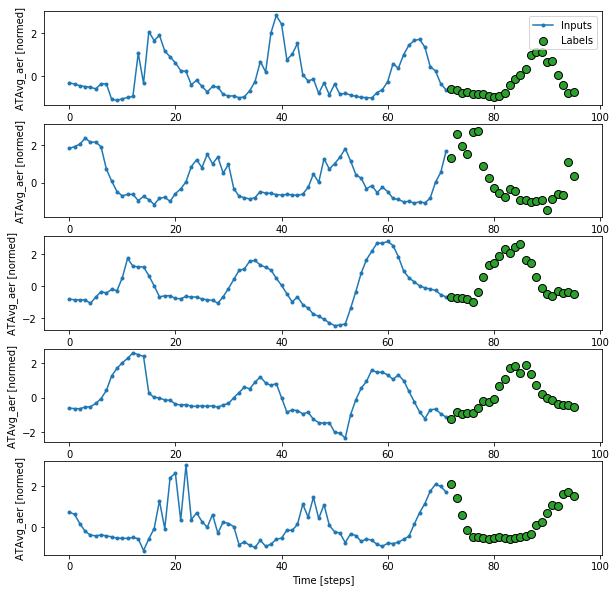

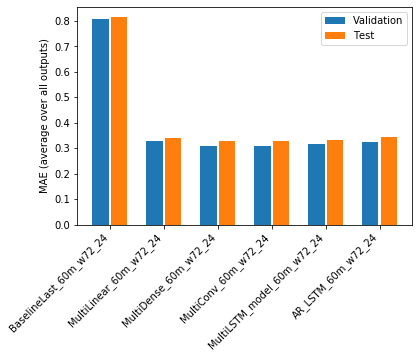

In [57]:
input_width = 72*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)

### 72 h + 48h

362/362 [==============================] - 6s 16ms/step - loss: 0.3283 - mean_absolute_error: 0.3316


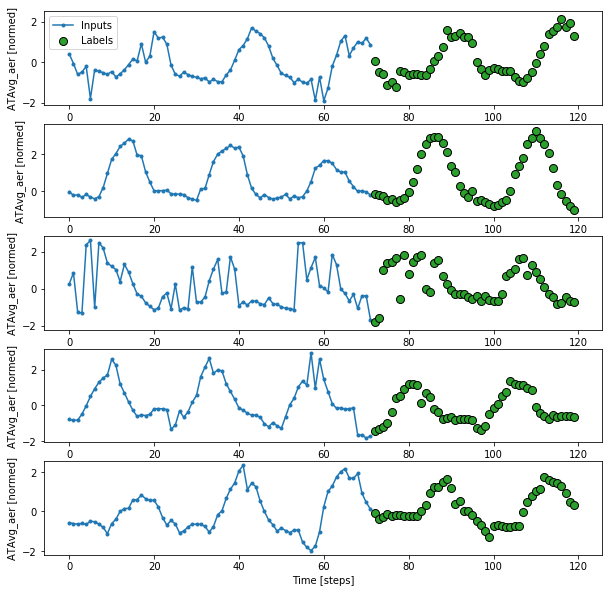

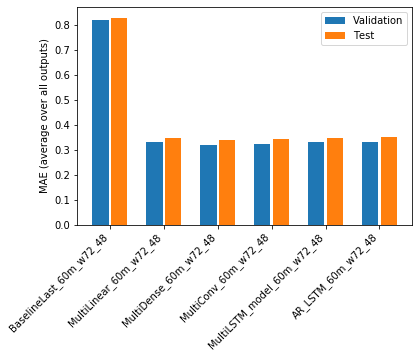

In [58]:
input_width = 72*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)
# file = f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_performance_times.csv'
# plot_times(file,y0=0.5,y1=1.5, nplots = 4, nrows=2, ncols = 2)